In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [2]:
# Formation of the model
def model(X,beta = None):    # X- Input; beta = weights
    if beta is None:
        beta = np.array([1.5,0.3,0.08,1,-0.6,3,-0.1,8,-1.3,1,-0.03,-1.15,3.5,0.95,-0.1,4.3,0.29,-2.5,-0.16,6.2])
    return np.sin(np.dot(beta[0],X[:,0]))+np.power((beta[1]*X[:,1]),1) + (X[:,2]**2-beta[2]) + beta[3]*np.log( X[:,3]) + beta[4]*X[:,4]+ \
    np.tanh(beta[5]*X[:,5]) + (X[:,6]**3-(beta[6]*X[:,6]**2))+ np.power(np.sin(X[:,7]),beta[7])+beta[8]*X[:,8]+np.exp(beta[9]*np.log(X[:,9]))+\
    np.cosh(np.dot(beta[10], X[:,10]))+np.exp(np.dot(beta[11], X[:,11]))+beta[12]*np.tanh(X[:,12]) - beta[13]*X[:,13] ** 2+np.cos(beta[14]*X[:,14])+\
    np.sin(np.dot(beta[15],X[:,15]))+np.exp(np.dot(beta[16],X[:,16])) + (X[:,17]**2-beta[17]) + beta[18]*np.sqrt((X[:,18])) + beta[19]*X[:,19]

In [3]:
# Geberating the dataset
rng = np.random.RandomState(1)
X = rng.rand(1000, 20) # Input Dataset with dimension 20
Y = model(X) # output with one dimension

# splitting the dataset into training and testing
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2) # Generating train and test dataset

all methods with co_des

In [9]:
from scipy.optimize import minimize, Bounds

class non_linear():
    def __init__(self,alpha,epochs = 1000,tol=1e-6):  
        self.alpha = alpha 
        self.epochs = epochs
        self.tol = tol
        self.coef_c = None   
        self.coef_l = None 
        self.coef_n = None 
    
    def loss(self,beta_j,X,Y,beta,j):  
        beta[j] = beta_j
        loss = (0.5/X.shape[0])* np.linalg.norm(Y- model(X,beta),ord=2)**2 + self.alpha* np.linalg.norm(beta,ord=1)
        return loss  

    def soft_threshold(self,rho,lamda):
        if rho < - lamda:
            return rho + lamda
        elif rho > lamda:
            return rho - lamda
        else: 
            return 0  
    
    def fit(self,X,Y):         
        
        # initializing weights for all 3 methods
        np.random.seed(123)
        beta_l =np.random.rand(X.shape[1])                       
        beta_n =np.random.rand(X.shape[1])
        beta_c =np.random.rand(X.shape[1])

        for iter in range(self.epochs): 
            # saving the old weights
            beta_old_l = np.copy(beta_l)  
            beta_old_n = np.copy(beta_n)  
            beta_old_c = np.copy(beta_c)           
            
            for j in range(len(beta_l)):  

                options = {'maxiter': 1000000} # maximum funciton evalutions                                     
                                            
                # Application of L-BFGS-B
                res_l = minimize(self.loss, x0=beta_l[j],args=(X,Y,beta_l,j), method='L-BFGS-B',jac = False,options=options,tol=1e-8)                
                # Application of Nelder Mead
                res_n = minimize(self.loss, x0=beta_n[j],args=(X,Y,beta_n,j), method='Nelder-Mead',jac = False,options=options,tol=1e-8)
                # Application of COBYLA
                res_c = minimize(self.loss, x0=beta_c[j],args=(X,Y,beta_c,j), method='COBYLA',jac = False,options=options,tol=1e-8)
                                    
                # Application of the soft thresholding function
                beta_l[j] = (self.soft_threshold(res_l.x,1e-4))
                beta_n[j] = (self.soft_threshold(res_n.x,1e-4))
                beta_c[j] = (self.soft_threshold(res_c.x,1e-4))
                

            # Checking the termination criterion
            if np.linalg.norm(beta_l - beta_old_l) < self.tol:
                print("Optimization converged after l", iter+1, "iterations")
                break  
            if np.linalg.norm(beta_n - beta_old_n) < self.tol:
                print("Optimization converged after n", iter+1, "iterations")
                break 
            if np.linalg.norm(beta_c - beta_old_c) < self.tol:
                print("Optimization converged after c", iter+1, "iterations")
                break      
                
        self.coef_c = beta_c    # saving the weights for COBYLA
        self.coef_l = beta_l    # saving the weights for L-BFGS-B
        self.coef_n = beta_n    # saving the weights for Nelder Mead
            
        return self
    
    def predict(self, X):
        y_l = model(X,self.coef_l)
        y_n = model(X,self.coef_n)
        y_c = model(X,self.coef_c)
                
        return y_l,y_n,y_c
    
    def NRMSE(self,y,ym):
        # y: Process output, ym: Model output or predictions
        error = np.zeros(len(y))

        for i in range(len(y)):
            error[i] = (y[i]-ym[i])**2
            
        return np.sqrt(np.mean((error)/np.char.chararray.var(y)))

In [6]:
lamda = [0,0.0001,0.001,0.01,0.1,1,10]

In [15]:
test_loss = []
wo_c = np.zeros((len(lamda),X.shape[1]))
wo_l = np.zeros((len(lamda),X.shape[1]))
wo_n = np.zeros((len(lamda),X.shape[1]))

Nr_c = []
Nr_l = []
Nr_n = []

for i,val in enumerate(lamda):
    opt_cb = non_linear(val)
    opt_cb.fit(X_train,Y_train)    
    wo_c[i,:] = opt_cb.coef_c
    wo_l[i,:] = opt_cb.coef_l
    wo_n[i,:] = opt_cb.coef_n
    y_l,y_n,y_c = opt_cb.predict(X_test) 
    test_loss.append((tf.keras.losses.mae(yp, Y_test)).numpy())
    Nr_c.append(opt_cb.NRMSE(Y_test,y_c))
    Nr_l.append(opt_cb.NRMSE(Y_test,y_l))
    Nr_n.append(opt_cb.NRMSE(Y_test,y_n))

Optimization converged after l 165 iterations
Optimization converged after l 165 iterations
Optimization converged after l 156 iterations
Optimization converged after l 140 iterations
Optimization converged after l 63 iterations
Optimization converged after l 38 iterations
Optimization converged after l 2 iterations


In [16]:
print(Nr_c)
print(Nr_l)
print(Nr_n)

[0.1994102597459581, 0.1992918878681242, 0.20014432000146737, 0.22094626989690216, 0.40254954633519713, 0.9559172091115392, 2.3555505853528644]


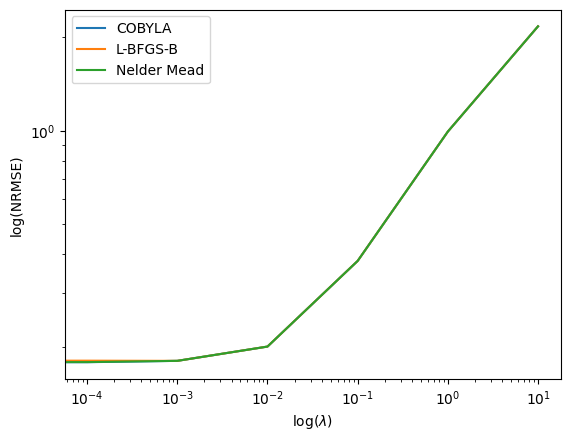

In [9]:
plt.plot(lamda,Nr_c,label='COBYLA')
plt.plot(lamda,Nr_l,label='L-BFGS-B')
plt.plot(lamda,Nr_n,label='Nelder Mead')
plt.xscale("log")
plt.yscale("log")
plt.xlabel('log($\\lambda$)')
plt.ylabel('log(NRMSE)')
plt.legend()
plt.show()

COBYLA without co and with epochs

In [11]:
np.random.seed(123)
class non_linear_all():
    def __init__(self,alpha,epochs = 1000):  
        self.alpha = alpha 
        self.epochs = epochs
        self.coef = None   
      
    def loss(self,beta,X,Y):       
        loss = (0.5/X.shape[0])* np.linalg.norm((Y- model(X,beta)),ord=2)**2 + self.alpha* np.linalg.norm(beta,ord=1)
        return loss  

    def soft_threshold(self,rho,lamda):
        if rho.all() < - lamda:
            return rho + lamda
        elif rho.all() > lamda:
            return rho - lamda
        else: 
            return 0  
    
    def fit(self,X,Y):         
        
        beta_l = np.ones(X.shape[1]) #                     
        beta_n =np.ones(X.shape[1])
        beta_c =np.ones(X.shape[1])  #np.ones(X.shape[1])                   

        options = {'maxiter': 100000,'disp':True}                                      
                                                            
        res_c = minimize(self.loss, x0=beta_c,args=(X,Y), method='COBYLA',jac = False, options=options,tol=1e-8)
        res_l = minimize(self.loss, x0=beta_l,args=(X,Y), method='L-BFGS-B',jac = False, options=options,tol=1e-8)
        res_n = minimize(self.loss, x0=beta_n,args=(X,Y), method='Nelder-Mead',jac = False, options=options,tol=1e-8)
                                                    
        beta_c = (self.soft_threshold(res_c.x,1e-5))
        beta_l = (self.soft_threshold(res_l.x,1e-5))
        beta_n = (self.soft_threshold(res_n.x,1e-5))
        print("Iterations c: ", res_c.nfev) 
        print("Iterations l: ", res_l.nfev)
        print("Iterations n: ", res_n.nfev)
            #print(beta)
                    
                
        self.coef_c = beta_c
        self.coef_l = beta_l
        self.coef_n = beta_n   
        return self
    
    def predict(self, X):
        y_c = model(X,self.coef_c)
        y_l = model(X,self.coef_l)
        y_n = model(X,self.coef_n)
                
        return y_c,y_l,y_n
    
    def NRMSE(self,y,ym):
        # y: Process output, ym: Model output or predictions
        error = np.zeros(len(y))

        for i in range(len(y)):
            error[i] = (y[i]-ym[i])**2
            
        return np.sqrt(np.mean((error)/np.char.chararray.var(y)))

In [12]:
test_loss_all = []
wo_c_all = np.zeros((len(lamda),X.shape[1]))
wo_l_all = np.zeros((len(lamda),X.shape[1]))
wo_n_all = np.zeros((len(lamda),X.shape[1]))
Nr_c_all = []
Nr_l_all = []
Nr_n_all = []

for i,val in enumerate(lamda):
    opt_cb = non_linear_all(val)
    opt_cb.fit(X_train,Y_train)    
    wo_c_all[i,:] = opt_cb.coef_c
    wo_l_all[i,:] = opt_cb.coef_l
    wo_n_all[i,:] = opt_cb.coef_n
    y_c_all,y_l_all,y_n_all = opt_cb.predict(X_test) 
    test_loss_all.append((tf.keras.losses.mae(yp_all, Y_test)).numpy())
    Nr_c_all.append(opt_cb.NRMSE(Y_test,y_c_all))
    Nr_l_all.append(opt_cb.NRMSE(Y_test,y_l_all))
    Nr_n_all.append(opt_cb.NRMSE(Y_test,y_n_all))

Iterations c:  100000
Iterations c:  45037
Iterations c:  46020
Iterations c:  2896
Iterations c:  1988
Iterations c:  1893
Iterations c:  1466


In [14]:
print(Nr_c_all)
print(Nr_l_all)
print(Nr_n_all)

[0.0059747153700002555, 0.025123514553824985, 0.03810328171144741, 0.0874806159017335, 0.39806523424320983, 0.9379855746039178, 2.3144938963480235]


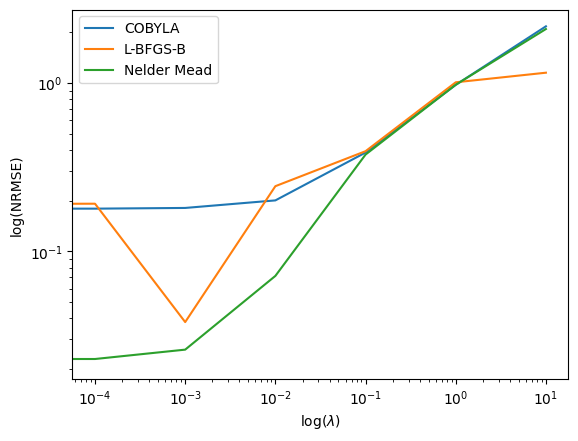

In [24]:
plt.plot(lamda,Nr_c_all,label='COBYLA')
plt.plot(lamda,Nr_l_all,label='L-BFGS-B')
plt.plot(lamda,Nr_n_all,label='Nelder Mead')
plt.xscale("log")
plt.yscale("log")
plt.xlabel('log($\\lambda$)')
plt.ylabel('log(NRMSE)')
plt.legend()
plt.show()

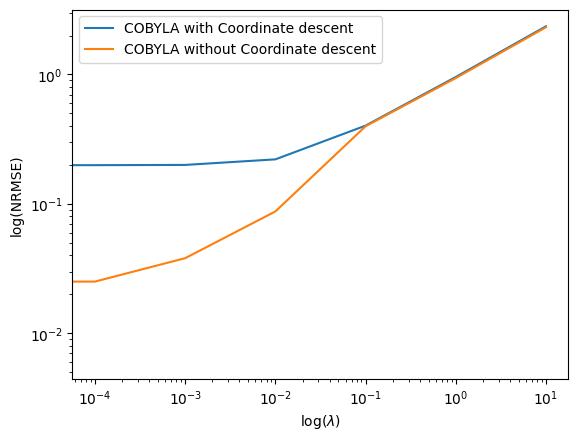

In [17]:
plt.plot(lamda,Nr_l,label='COBYLA with Coordinate descent')
plt.plot(lamda,Nr_c_all,label='COBYLA without Coordinate descent')
plt.xscale("log")
plt.yscale("log")
plt.xlabel('log($\\lambda$)')
plt.ylabel('log(NRMSE)')
plt.legend()
plt.show()